# Similarités entre séries

_recherche d'une mesure de similarité pertinente, associée à une feature representation pertinente_



In [5]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
import seaborn as sns
#using https://github.com/amueller/word_cloud
from wordcloud import WordCloud

from utils.load_data import getMostImportantSeries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize

plt.style.use('seaborn-white')
%matplotlib inline

#dataset path
path = "dataset"

Reprenons notre liste de séries célèbres, étoffée cette fois-ci: la liste contient **44 séries de plusieurs genres différents**, triés de manière à former des "blocs" de séries du même genre.

In [2]:
series = ['2733_NCIS__Los_Angeles', '2956_Criminal_Minds', '1041_CSI__Crime_Scene_Investigation', '1910_NCIS',
 '1830_CSI__Miami', '207_Bones', '2212_The_Mentalist', '2767_The_Blacklist', '413_Dexter', '1845_Sherlock_(2010)',
 '884_The_X-Files', '3259_Stargate_SG-1', '381_Star_Trek__The_Next_Generation', '2120_Doctor_Who_(1963)',
 '2091_Star_Trek__Deep_Space_Nine', '384_Twilight_Zone', '186_Doctor_Who', '25_Friends', '1704_Rick_and_Morty',
 '2469_The_Simpsons', '2556_The_Big_Bang_Theory', '292_Modern_Family', '1718_South_Park', '95_How_I_Met_Your_Mother',
 '3012_Grey_s_Anatomy', '2261_Buffy_The_Vampire_Slayer', '175_The_Walking_Dead', '1262_Lost', '1039_Narcos',
 '818_Gomorra_(2014)', '2123_Sense8', '3280_Peaky_Blinders', '121_Suits', '76_Breaking_Bad', '217_Game_of_Thrones',
 '2567_House', '1701_Outlander', '2936_Desperate_Housewives', '2053_Charmed', '345_Dallas', '1641_Pretty_Little_Liars',
 '3314_Shameless', '1906_The_Vampire_Diaries', '196_Smallville']

print(len(series))

44


In [7]:
corpus = []

for serie in series:
    listepisodes = glob.glob(path+"/"+serie+"/*/*.tokens")
    text = ""
    for episode in listepisodes:
        with open(episode, "r", encoding="utf-8") as file:
            text += " " + file.read()
    corpus.append(text)
print(len(corpus))

44


#### Matrice de similarité:

Nous construisons une matrice de similarité entre séries, de manière à indiquer la ressemblance entre deux séries. Nous commençons par une approche classique qui considère des modèles vectoriels bag-of-words des séries, et effectue une similarité cosinus entre ces vecteurs.

In [6]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=1000)
x = tfidf_vect.fit(corpus)
vec = tfidf_vect.transform(corpus)

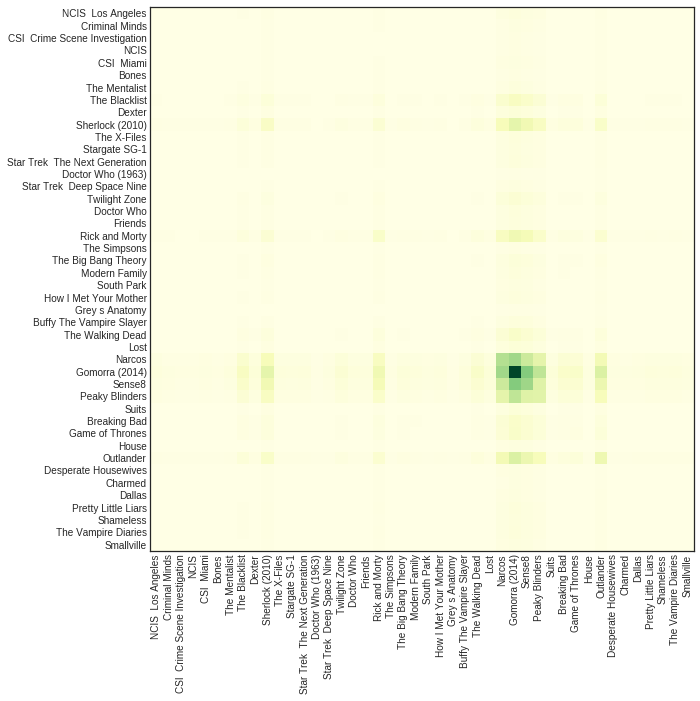

In [84]:
sim = np.zeros((len(series), len(series)))

for i in range(len(corpus)):
    for j in range(len(corpus)):
        dot = np.asscalar(vec[i].dot(vec[j].T).todense())
        norm1 = np.asscalar(vec[i].dot(vec[i].T).todense())
        norm2 = np.asscalar(vec[j].dot(vec[j].T).todense())
        sim[i][j] += dot/(norm1 * norm2) #sim cosinus

simvisualise = sim / np.sum(sim)
sim = normalize(sim, norm='l1', axis=0)

plt.figure(figsize=(10,10))
plt.imshow(simvisualise, cmap='YlGn', interpolation='nearest')
plt.xticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series], rotation='vertical')
plt.yticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series])
plt.show()

In [85]:
print("series les plus proches de Esprits criminels:")

mdr = [(series[i], a) for i, a in enumerate(sim[series.index('2956_Criminal_Minds')])]
for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:7]]:
    print("  ", " ".join(b))

print("\nseries les plus proches de Dr. House:")

mdr = [(series[i], a) for i, a in enumerate(sim[series.index('2567_House')])]
for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:7]]:
    print("  ", " ".join(b))
    
print("\nseries les plus proches de Les Simpsons:")

mdr = [(series[i], a) for i, a in enumerate(sim[series.index('2469_The_Simpsons')])]
for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:7]]:
    print("  ", " ".join(b))
    
print("\nseries les plus proches de Star trek - the next generation:")

mdr = [(series[i], a) for i, a in enumerate(sim[series.index('381_Star_Trek__The_Next_Generation')])]
for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:7]]:
    print("  ", " ".join(b))

series les plus proches de Esprits criminels:
   Criminal Minds
   CSI  Crime Scene Investigation
   CSI  Miami
   NCIS  Los Angeles
   NCIS
   Bones
   The X-Files

series les plus proches de Dr. House:
   House
   Grey s Anatomy
   Suits
   Charmed
   Pretty Little Liars
   Dexter
   Smallville

series les plus proches de Les Simpsons:
   The Simpsons
   Modern Family
   How I Met Your Mother
   South Park
   The Big Bang Theory
   Rick and Morty
   Desperate Housewives

series les plus proches de Star trek - the next generation:
   Star Trek  The Next Generation
   Star Trek  Deep Space Nine
   Stargate SG-1
   Doctor Who (1963)
   Doctor Who
   Outlander
   Game of Thrones


#### Résultat:

On remarque la présence d'un carré assez sombre en haut à gauche: le modèle a reconnu une certaine similarité entre les séries de type "policier" comme esprits criminels, ou NCIS. Un autre "carré" est aussi présent dans l'image, qui correspond à une certaine similarité entre les séries dites "comiques" comme les simpsons, modern family, south park...

Cependant ce modèle est très mauvais: en particulier, aucune forte similarité n'est détectée entre les séries de science-fiction!

On constate néanmoins que les séries recommendées pour star trek sont correctes: ce sont toutes des séries de science-fiction dans un genre proche.

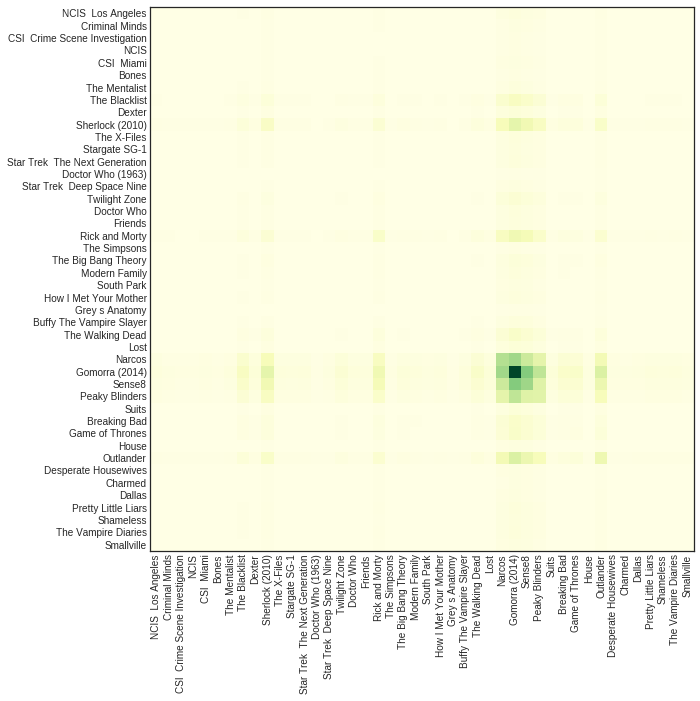

In [73]:
counter_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
x = counter_vect.fit(corpus)

vec = counter_vect.transform(corpus)

sim = np.zeros((len(series), len(series)))

for i in range(len(corpus)):
    for j in range(len(corpus)):
        dot = np.asscalar(vec[i].dot(vec[j].T).todense())
        norm1 = np.asscalar(vec[i].dot(vec[i].T).todense())
        norm2 = np.asscalar(vec[j].dot(vec[j].T).todense())  
        sim[i][j] += dot/(norm1 * norm2) #sim cosinus

simvisualise = sim / np.sum(sim)
sim = normalize(sim, norm='l1', axis=0)

plt.figure(figsize=(10,10))
plt.imshow(simvisualise, cmap='YlGn', interpolation='nearest')
plt.xticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series], rotation='vertical')
plt.yticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series])
plt.show()

In [16]:
print("series les plus proches de Esprits criminels:")

mdr = [(series[i], a) for i, a in enumerate(sim[series.index('2956_Criminal_Minds')])]
for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:7]]:
    print("  ", " ".join(b))

print("\nseries les plus proches de Dr. House:")

mdr = [(series[i], a) for i, a in enumerate(sim[series.index('2567_House')])]
for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:7]]:
    print("  ", " ".join(b))
    
print("\nseries les plus proches de Les Simpsons:")

mdr = [(series[i], a) for i, a in enumerate(sim[series.index('2469_The_Simpsons')])]
for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:7]]:
    print("  ", " ".join(b))
    
print("\nseries les plus proches de Star trek - the next generation:")

mdr = [(series[i], a) for i, a in enumerate(sim[series.index('381_Star_Trek__The_Next_Generation')])]
for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:7]]:
    print("  ", " ".join(b))
    
print("\nseries les plus proches de Smallville:")

mdr = [(series[i], a) for i, a in enumerate(sim[series.index('196_Smallville')])]
for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:7]]:
    print("  ", " ".join(b))

series les plus proches de Esprits criminels:
   Criminal Minds
   CSI  Crime Scene Investigation
   The Blacklist
   CSI  Miami
   The X-Files
   Bones
   Dexter

series les plus proches de Dr. House:
   House
   Grey s Anatomy
   Dexter
   Suits
   Desperate Housewives
   Pretty Little Liars
   Criminal Minds

series les plus proches de Les Simpsons:
   The Simpsons
   South Park
   Modern Family
   Rick and Morty
   How I Met Your Mother
   Game of Thrones
   Twilight Zone

series les plus proches de Star trek - the next generation:
   Star Trek  The Next Generation
   Stargate SG-1
   Star Trek  Deep Space Nine
   Doctor Who (1963)
   Outlander
   Doctor Who
   Game of Thrones

series les plus proches de Smallville:
   Smallville
   Pretty Little Liars
   Sense8
   Charmed
   Suits
   Buffy The Vampire Slayer
   Dexter


#### Résultat:

Ce modèle parait également à première vue très bon, du moins pour les 5-6 premières recommendations.

Essayons de retirer du corpus les mots trop particuliers à une série, afin d'étudier son impact sur la similarité:

In [10]:
from utils.featureExtraction import NEextractor

neExtractor = NEextractor()

dic = neExtractor.extract(path, series, includeAll=True, globalcutoff=30, individualcutoff=10)
neExtractor.save("customstopwords")

listedemots = []
for a in dic:
    listedemots += dic[a]

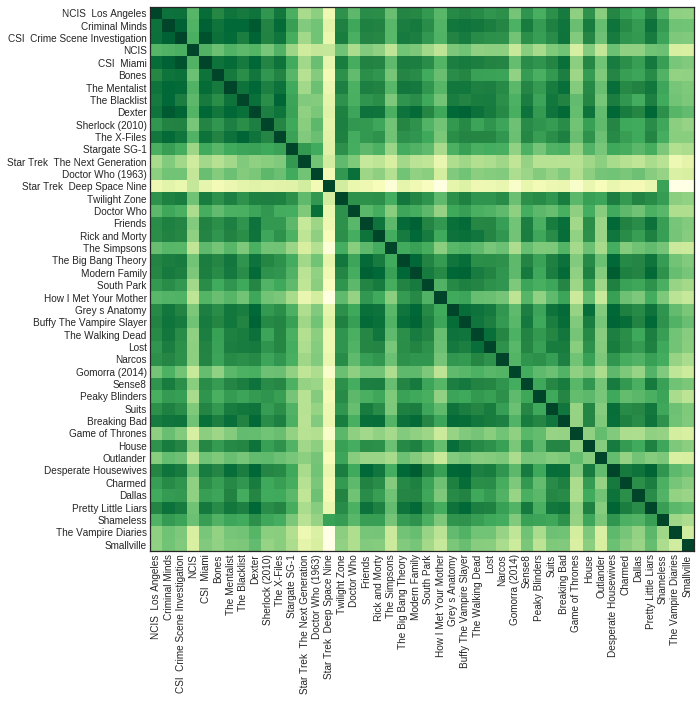

In [13]:
customstopwords = stopwords.words('english') + ["yes","yeah","hmm","hey",
                                                "nah","oh","uh","okay","okey",
                                                "ye","hey","na","ca","ok","got","come","back","up"]
customstopwords += listedemots

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=1000, stop_words=customstopwords)
x = tfidf_vect.fit(corpus)
vec = tfidf_vect.transform(corpus)

sim = np.zeros((len(series), len(series)))

for i in range(len(corpus)):
    for j in range(len(corpus)):
        dot = np.asscalar(vec[i].dot(vec[j].T).todense())
        norm1 = np.asscalar(vec[i].dot(vec[i].T).todense())
        norm2 = np.asscalar(vec[j].dot(vec[j].T).todense())
        sim[i][j] += dot/(norm1 * norm2) #sim cosinus

simvisualise = sim / np.sum(sim)
sim = normalize(sim, norm='l1', axis=0)

plt.figure(figsize=(10,10))
plt.imshow(simvisualise, cmap='YlGn', interpolation='nearest')
plt.xticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series], rotation='vertical')
plt.yticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series])
plt.show()

In [15]:
print("series les plus proches de Esprits criminels:")

mdr = [(series[i], a) for i, a in enumerate(sim[series.index('2956_Criminal_Minds')])]
for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:7]]:
    print("  ", " ".join(b))

print("\nseries les plus proches de Dr. House:")

mdr = [(series[i], a) for i, a in enumerate(sim[series.index('2567_House')])]
for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:7]]:
    print("  ", " ".join(b))
    
print("\nseries les plus proches de Les Simpsons:")

mdr = [(series[i], a) for i, a in enumerate(sim[series.index('2469_The_Simpsons')])]
for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:7]]:
    print("  ", " ".join(b))
    
print("\nseries les plus proches de Star trek - the next generation:")

mdr = [(series[i], a) for i, a in enumerate(sim[series.index('381_Star_Trek__The_Next_Generation')])]
for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:7]]:
    print("  ", " ".join(b))
    
print("\nseries les plus proches de Smallville:")

mdr = [(series[i], a) for i, a in enumerate(sim[series.index('196_Smallville')])]
for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:7]]:
    print("  ", " ".join(b))

series les plus proches de Esprits criminels:
   Criminal Minds
   CSI  Crime Scene Investigation
   The Blacklist
   CSI  Miami
   The X-Files
   Bones
   Dexter

series les plus proches de Dr. House:
   House
   Grey s Anatomy
   Dexter
   Suits
   Desperate Housewives
   Pretty Little Liars
   Criminal Minds

series les plus proches de Les Simpsons:
   The Simpsons
   South Park
   Modern Family
   Rick and Morty
   How I Met Your Mother
   Game of Thrones
   Twilight Zone

series les plus proches de Star trek - the next generation:
   Star Trek  The Next Generation
   Stargate SG-1
   Star Trek  Deep Space Nine
   Doctor Who (1963)
   Outlander
   Doctor Who
   Game of Thrones

series les plus proches de Smallville:
   Smallville
   Pretty Little Liars
   Sense8
   Charmed
   Suits
   Buffy The Vampire Slayer
   Dexter


Ce modèle aussi parait très bon, et donne exactement les mêmes résultats. Un problème se pose donc:

>Comment évaluer la qualité d'un modèle de similarité?

Nous devons utiliser une ou plusieurs mesures de similarité pour évaluer qualitativement nos modèles, afin d'être en mesure de choisir le meilleur.

In [10]:
series_df = pd.read_csv("series.csv")

genres = ['Drama', 'Comedy', 'Action', 'Science-Fiction']

series_df.head(10)

,Unnamed: 0,seriesname,id,imdbId,zap2itId,genres
0,0,2318_Raising_the_Bar,82340,tt1001558,SH01072534,Drama
1,1,1159_Rejseholdet_(Unit_One),78859,tt0220261,NaN,Drama
2,2,1821_Til_Death,79384,tt0759475,EP00846488,Comedy
3,3,1631_Finding_Carter,277991,tt3186138,EP01876566,Drama
4,4,1476_Dance_Academy,167461,tt1551948,NaN,Drama-Family
5,5,1193_Witches_of_East_End,267259,tt2288064,EP01792412,Drama-Fantasy-Suspense
6,6,3142_Joey,72920,tt0375355,SH677997,Comedy-Romance
7,7,2155_Star_Trek_The_Animated_Series,73566,tt0069637,NaN,Action-Adventure-Animation-Drama-Science-Fiction
8,8,2510_Whose_Line_Is_It_Anyway_,78521,tt0094580,NaN,Comedy
9,9,3172_How_the_Universe_Works,159651,tt1832668,EP01253151,Documentary
